# Import Statements

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import torchvision.transforms as T
import torchvision.datasets as dset
import torch.optim as optim
import torch.nn.functional as F

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# GPU available
print(device)

cuda


In [4]:
dtype = torch.float32

In [5]:
transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.ToTensor()
])

In [6]:
train_data = dset.ImageFolder("../data/images/train", transform = transform)

In [7]:
validation_data = dset.ImageFolder("../data/images/validation", transform=transform)

In [8]:
performance = {
    "loss_history" : [],
    "validation_acc" : [],
    "training_acc" : []
}

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [10]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [11]:
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False)

In [12]:
dataiter = iter(train_loader)

images, labels = dataiter.next()

expressions = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "neutral",
    5: "sad",
    6: "surprise"
}

In [13]:
int(labels[0].numpy())

4

Random Sample: Label - happy


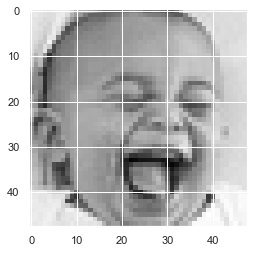

In [14]:
random_idx = np.random.randint(0,64)
print(f"Random Sample: Label - {expressions[int(labels[random_idx].numpy())]}")
plt.imshow(np.transpose(images[random_idx].numpy(), (1, 2, 0)))

In [41]:
from torchvision.utils import make_grid
def show_batch(loader):
    for images, labels in loader:
        # show first batch images
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1,2,0)/2 + 0.5)
        break

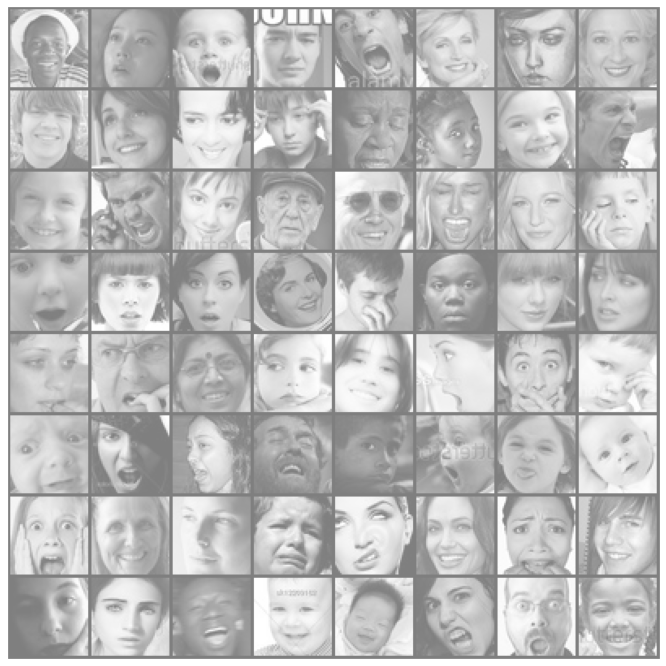

In [42]:
show_batch(train_loader)

In [43]:
num_classes = 7
class_count = [0] * num_classes

for img, label in train_data:
    class_count[label] += 1
    
print(class_count)

[3993, 436, 4103, 7164, 4982, 4938, 3205]


C:\Project_Files\Anaconda3\envs\01-pytorch-basics\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


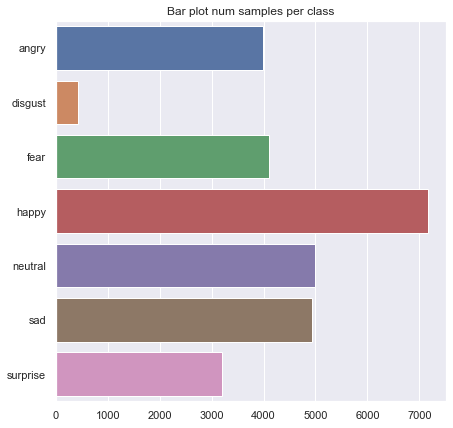

In [44]:
plt.figure(figsize=(7,7))
plt.title("Bar plot num samples per class")
sns.barplot(class_count, train_data.classes)

In [15]:
def check_accuracy(loader, model):
    print("Accuracy against Validation set")
    correct_results = 0
    total_samples = 0
    
    # set model in evaluation mode
    model.eval()
    
    # no_grad - compute no gradients
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            # print("scores: ", scores)
            _, preds = scores.max(1)
            # print("underscore: ", _)
            
            correct_results += (preds == y).sum()
            total_samples += preds.size(0)
            
        accuracy = float(correct_results) / total_samples
        print(" %d correct out of %d - accuracy (%.2f) " % (correct_results, total_samples, 100 * accuracy))
    return accuracy    

In [16]:
def train(model, optimizer, epochs=1):
    model = model.to(device=device)
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        num_correct = 0
        num_samples = 0
        
        for index, (x, y) in enumerate(train_loader):
            # training mode
            model.train()
            
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
            loss = F.cross_entropy(scores, y)
            
            # zero the gradients
            optimizer.zero_grad()
            # backward the computation graph
            loss.backward()
            # update the parameters
            optimizer.step()
            
            # printing results every 100th loader
            if index % 100 == 0:
                print(f"Iteration = {index}, loss = {loss.item():.2f}")
                
                train_accuracy = float(num_correct) / num_samples
                val_accuracy = check_accuracy(validation_loader, model)
                
                performance["training_acc"].append(train_accuracy)
                performance["validation_acc"].append(val_accuracy)
            

In [17]:
layer1 = nn.Sequential(
    nn.Conv2d(3, 512, kernel_size=(3,3), bias=True, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))
)

In [18]:
layer2 = nn.Sequential(
    nn.Conv2d(512, 128, kernel_size=(3,3), bias=True, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))
)

In [19]:
layer3 = nn.Sequential(
    nn.Conv2d(128, 64, kernel_size=(3,3), bias=True, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))
)

In [20]:
layer4 = nn.Sequential(
    nn.Conv2d(64, 256, kernel_size=(3,3), bias=True, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))
)

In [21]:
fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256 * 3 * 3, 7)
)

In [22]:
model = nn.Sequential(
    layer1, layer2, layer3, layer4, fc
)

In [23]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [24]:
optimizer.zero_grad()

In [47]:
# total number of parameters
model_total_parameters = [p.numel() for p in model.parameters()]
print(f"Model parameters: {model_total_parameters},\ntotal: {sum(model_total_parameters)}")

Model parameters: [13824, 512, 512, 512, 589824, 128, 128, 128, 73728, 64, 64, 64, 147456, 256, 256, 256, 16128, 7],
total: 843847


In [25]:
train(model, optimizer, epochs=5)

Epoch: 0
Iteration = 0, loss = 1.97
Accuracy against Validation set
 1018 correct out of 7066 - accuracy (14.41) 
Iteration = 100, loss = 1.77
Accuracy against Validation set
 2607 correct out of 7066 - accuracy (36.89) 
Iteration = 200, loss = 1.41
Accuracy against Validation set
 2934 correct out of 7066 - accuracy (41.52) 
Iteration = 300, loss = 1.40
Accuracy against Validation set
 3042 correct out of 7066 - accuracy (43.05) 
Iteration = 400, loss = 1.24
Accuracy against Validation set
 3331 correct out of 7066 - accuracy (47.14) 
Epoch: 1
Iteration = 0, loss = 1.18
Accuracy against Validation set
 3157 correct out of 7066 - accuracy (44.68) 
Iteration = 100, loss = 1.03
Accuracy against Validation set
 3273 correct out of 7066 - accuracy (46.32) 
Iteration = 200, loss = 1.44
Accuracy against Validation set
 3560 correct out of 7066 - accuracy (50.38) 
Iteration = 300, loss = 1.32
Accuracy against Validation set
 3675 correct out of 7066 - accuracy (52.01) 
Iteration = 400, loss =

In [26]:
performance

{'loss_history': [],
 'validation_acc': [0.14407019530144352,
  0.3689499009340504,
  0.41522785168412113,
  0.43051231248230964,
  0.47141239739598073,
  0.44678743277667704,
  0.46320407585621287,
  0.5038211151995471,
  0.5200962354939145,
  0.46787432776677046,
  0.45782621001981316,
  0.4906594961788848,
  0.4895273138975375,
  0.5104726861024625,
  0.5553354090008491,
  0.5680724596660063,
  0.5578828191338806,
  0.4726861024624965,
  0.5516558165864704,
  0.5482592697424286,
  0.5793942824794792,
  0.5452872912538919,
  0.5673648457401642,
  0.5656665723181432,
  0.5570336824228701],
 'training_acc': [0.15625,
  0.2817141089108911,
  0.3314676616915423,
  0.3651370431893688,
  0.39222256857855364,
  0.5625,
  0.5023205445544554,
  0.5049751243781094,
  0.5115240863787376,
  0.5162484413965087,
  0.609375,
  0.552444306930693,
  0.558768656716418,
  0.5566860465116279,
  0.5579021197007481,
  0.546875,
  0.5908106435643564,
  0.5901741293532339,
  0.5873650332225914,
  0.58899625

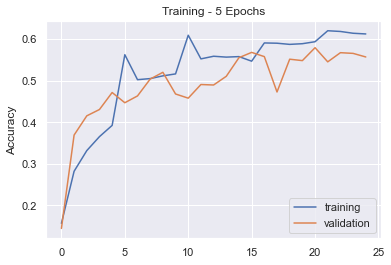

In [31]:
plt.plot(performance["training_acc"], label="training")
plt.plot(performance["validation_acc"], label="validation")
plt.ylabel("Accuracy")
plt.title("Training - 5 Epochs")
plt.legend()
plt.show()

In [35]:
torch.save(model.state_dict(), 'face-expressions-cnn.pth')